# Olist E-Commerce and Marketing Datasets

The objective for this notebook is to determine what factors have the most significance in predicting customer satisfaction in e-commerce?

This project revolves around the Brazilian e-commerce, Olist.

To begin , we will go the `data preparation` process which includes the Collection, Curation and Preparation of the datasets.

Next, for the `exploratory data analysis` using graphical tools to better understand the essential data we required.

Subsequently, we will be using the `Machine Learning Techiniques` to attempt to solve our problem.

Lastly, we will come up with a `conclusion` to what the company should take to improve customer satisfaction.

# 1. Libraries

In [1]:
# Standard Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import datetime as dt
import numpy as np
sb.set()

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import graphviz
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics

# Grid Search & ROC-AUC Libraries
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

Import the necessary datasets. 

`olist_order_reviews_dataset`, `olist_orders_dataset`, `olist_order_payments_dataset`, `olist_order_items_dataset`

In [2]:
review_data = pd.read_csv("archive/olist_order_reviews_dataset.csv")
order_data = pd.read_csv("archive/olist_orders_dataset.csv")
payment_data = pd.read_csv("archive/olist_order_payments_dataset.csv")
order_items_data = pd.read_csv("archive/olist_order_items_dataset.csv")

# 2. Data Preparation

Merge the 3 datasets under the column `"order_id"`

In [3]:
main_data = pd.merge(pd.merge(review_data,order_data, on = "order_id"),payment_data, on = "order_id")
main_data = pd.merge(main_data,order_items_data, on = "order_id")
main_data.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,...,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,...,1,credit_card,8,397.26,1,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-01-18 15:47:59,185.00,13.63
1,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,...,1,credit_card,8,397.26,2,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-01-18 15:47:59,185.00,13.63
2,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,8a2e7ef9053dea531e4dc76bd6d853e6,delivered,2018-02-28 12:25:19,...,1,credit_card,1,88.09,1,be0dbdc3d67d55727a65d4cd696ca73c,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-06 12:48:39,79.79,8.30
3,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24,e226dfed6544df5b7b87a48208690feb,delivered,2018-02-03 09:56:22,...,1,credit_card,1,194.12,1,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-02-08 10:31:15,149.00,45.12
4,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,de6dff97e5f1ba84a3cd9a3bc97df5f6,delivered,2017-04-09 17:41:13,...,1,credit_card,1,222.84,1,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,2017-04-13 17:55:19,179.99,42.85


In [4]:
main_data['order_approved_at'] = pd.to_datetime(main_data['order_approved_at']).dt.date
main_data['order_estimated_delivery_date'] = pd.to_datetime(main_data['order_estimated_delivery_date']).dt.date
main_data['order_delivered_customer_date'] = pd.to_datetime(main_data['order_delivered_customer_date']).dt.date

Obtain the `'delivery_days', 'estimated_days', 'difference_days'.`

In [5]:
main_data['delivery_days'] = (main_data['order_delivered_customer_date']-(main_data['order_approved_at'])).dt.days
main_data['estimated_days'] = (main_data['order_estimated_delivery_date']-(main_data['order_approved_at'])).dt.days
main_data['difference_days'] = (main_data['estimated_days'] - main_data['delivery_days'])

Classify the 5 categories of review_score into 2 classes, 'Good' and 'Bad.

`Good` : revew_score of 4 and 5

`Bad` : review_score of 3 and below

In [48]:
main_data['review_score_goodbad'] = main_data['review_score'].apply(lambda x: 'Good' if x > 3.0 else 'Bad')

Create a new dataframe to store the predictors and the response.

Clean the data by dropping all unecessary columns and rows that contain non-applicable values.

In [49]:
clean_data = pd.DataFrame(main_data[['difference_days','delivery_days', 'freight_value','price','payment_installments','review_score','review_score_goodbad']])
clean_data = clean_data.dropna()
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115712 entries, 0 to 118314
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   difference_days       115712 non-null  float64
 1   delivery_days         115712 non-null  float64
 2   freight_value         115712 non-null  float64
 3   price                 115712 non-null  float64
 4   payment_installments  115712 non-null  int64  
 5   review_score          115712 non-null  int64  
 6   review_score_goodbad  115712 non-null  object 
dtypes: float64(4), int64(2), object(1)
memory usage: 7.1+ MB


# 3. Exploratory Data Analysis

Plot the `"review_score" and "review_score_goodbad"` countplot.

5    66131
4    22207
1    13608
3     9760
2     4006
Name: review_score, dtype: int64

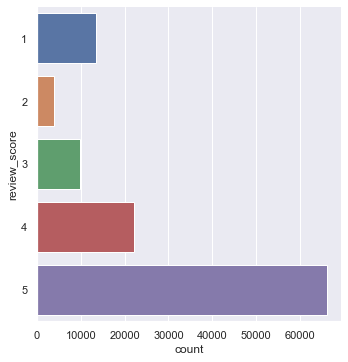

In [50]:
sb.catplot(y = "review_score", data = clean_data, kind = "count")
clean_data["review_score"].value_counts()

Good    88338
Bad     27374
Name: review_score_goodbad, dtype: int64

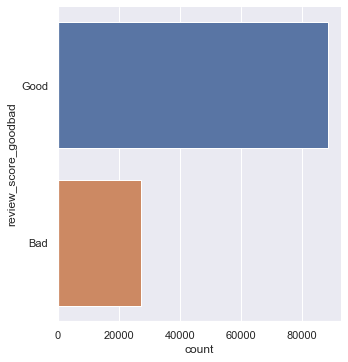

In [54]:
sb.catplot(y = "review_score_goodbad", data = clean_data, kind = "count")
clean_data["review_score_goodbad"].value_counts()

In [51]:
print("Ratio of Good : Bad |", 88338/27374,": 1")

Ratio of Good : Bad | 3.227076788193176 : 1


Split the "clean_data" dataset into `predictors, X` and `response, y`

In [52]:
y = pd.DataFrame(clean_data['review_score_goodbad'])
X = pd.DataFrame(clean_data[['difference_days','delivery_days', 'freight_value', 'price','payment_installments']])

In [53]:
X.describe()

,difference_days,delivery_days,freight_value,price,payment_installments
count,115712.000000,115712.000000,115712.000000,115712.000000,115712.000000
mean,12.048724,11.908894,19.982124,119.912584,2.940991
std,10.161092,9.423178,15.718932,182.679052,2.776355
min,-188.000000,-7.000000,0.000000,0.850000,0.000000
25%,7.000000,6.000000,13.080000,39.900000,1.000000
50%,13.000000,10.000000,16.280000,74.900000,2.000000
75%,17.000000,15.000000,21.160000,132.900000,4.000000
max,147.000000,208.000000,409.680000,6735.000000,24.000000


Draw the distributions of all variables.

Red  : "difference_days"

Green: "delivery_days"

Blue : "freight_value"

Orange: "price"

Purple: "payment_installments"

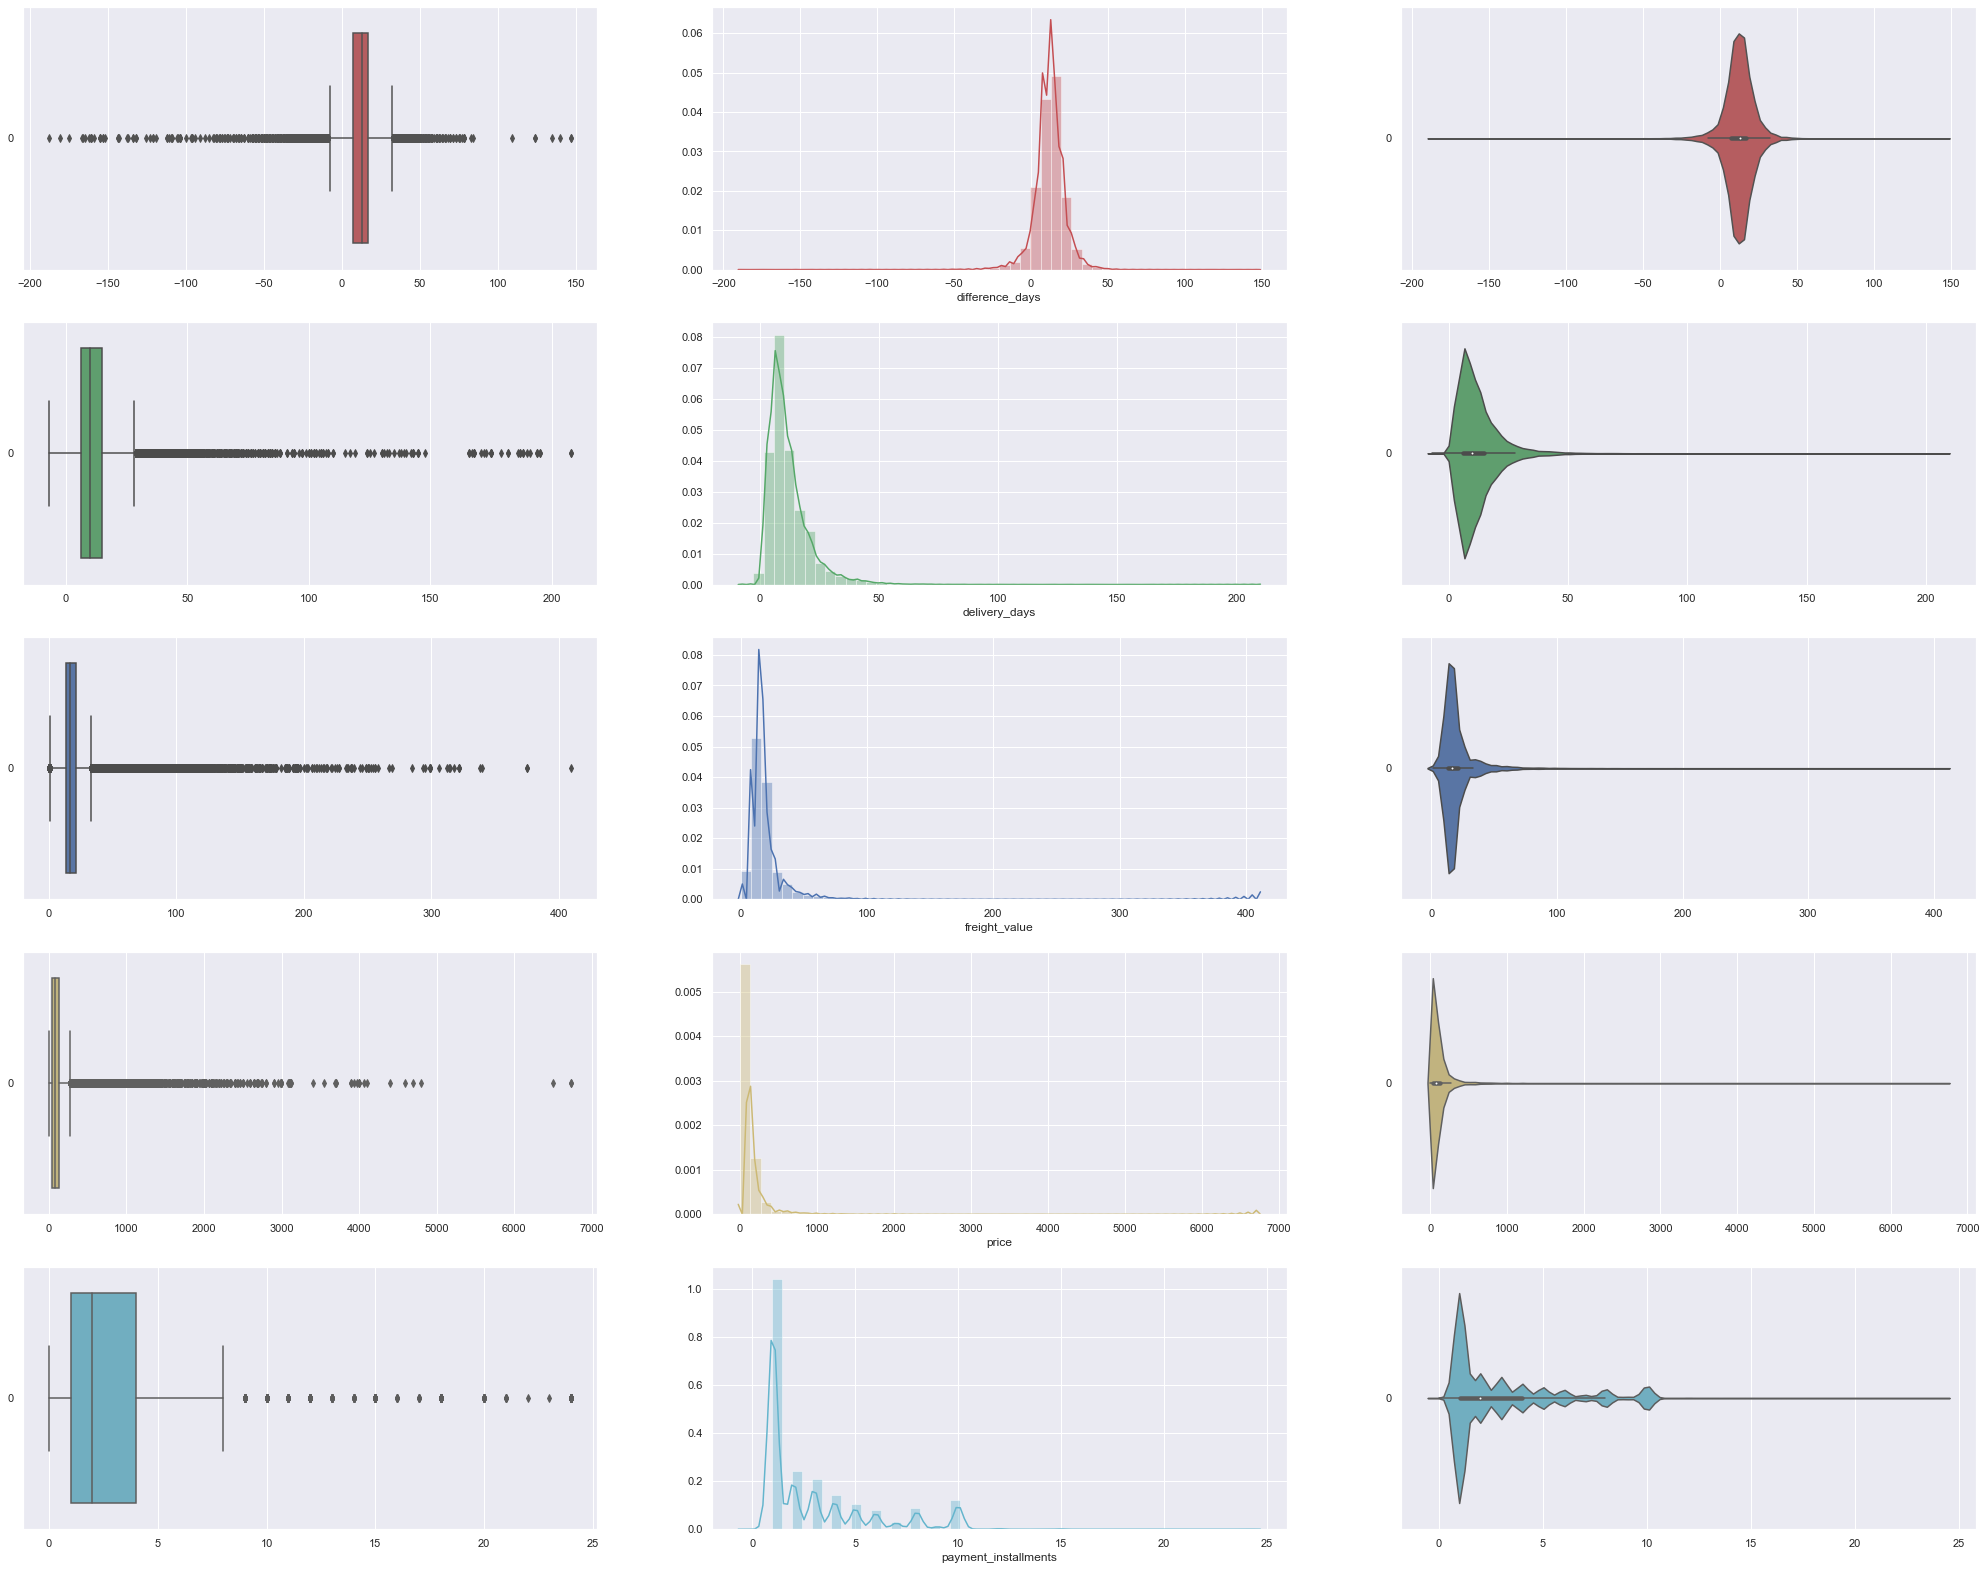

In [13]:
f, axes = plt.subplots(5, 3, figsize=(35, 28))

colours = ['r','g','b','y','c']
count = 0
for var in X:
    sb.boxplot(data = X[var], orient = "h", color = colours[count], ax = axes[count,0])
    sb.distplot(X[var],  color = colours[count],ax = axes[count,1])
    sb.violinplot(data = X[var], orient = "h", color = colours[count], ax = axes[count,2])
    count += 1

Using train-test split, split the datasets into train and test set.

Use stratify to keep the proportion of the classes intact even after splitting into the respective sets.


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify = y, test_size =0.25)
trainDF = pd.concat([y_train, X_train], axis = 1).reindex(y_train.index)

# 4. Machine Learning Technique

## Multi-variate Decision Tree Classifier

Using `Grid Search` for a range of depth (maximum of 8 to prevent overfitting) for the weighted decision tree and discover which of the depth results in the best ROC-AUC score.

In [15]:
# define model
model = DecisionTreeClassifier(class_weight = 'balanced')

# define grid
depth = [4,5,6,7,8]
param_grid = dict(max_depth=depth)

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

# execute the grid search
grid_result = grid.fit(X, y)

# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.663316 using {'max_depth': 8}
0.645152 (0.006311) with: {'max_depth': 4}
0.650060 (0.006764) with: {'max_depth': 5}
0.656666 (0.006795) with: {'max_depth': 6}
0.661099 (0.007203) with: {'max_depth': 7}
0.663316 (0.007023) with: {'max_depth': 8}


Create the decision tree object & train the decision tree model using the train dataset

In [34]:
dectree = DecisionTreeClassifier(max_depth = 8, class_weight = 'balanced')  
dectree.fit(X_train, y_train)                   

DecisionTreeClassifier(class_weight='balanced', max_depth=8)

Predict Response corresponding to Predictors

In [35]:
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)

Check the Goodness of Fit (on Train Data)

Goodness of Fit of Model Train Dataset
Classification Accuracy : 0.7190841629793511
True Positive Rate 	: 0.7990128748886843
True Negative Rate 	: 0.4611563002289221
False Positive Rate 	: 0.5388436997710779
False Negative Rate 	: 0.20098712511131572
Total TP + TN       	: 62405



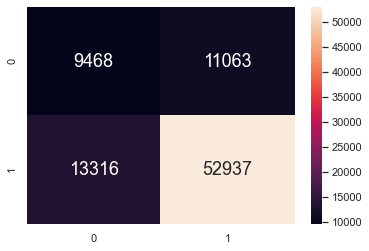

In [36]:
print("Goodness of Fit of Model Train Dataset")
print("Classification Accuracy :", dectree.score(X_train, y_train))
CM = confusion_matrix(y_train, y_train_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
print("True Positive Rate \t:",TP/(TP+FN))
print("True Negative Rate \t:", TN/(TN+FP))
print("False Positive Rate \t:", FP/(FP+TN))
print("False Negative Rate \t:", FN/(FN+TP))
print("Total TP + TN       \t:", TP+TN)
print()
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})

Check the Goodness of Fit (on Test Data)

Goodness of Fit of Model Test Dataset
Classification Accuracy : 0.7118017146017699
True Positive Rate 	: 0.7957889970568259
True Negative Rate 	: 0.4407423644600322
False Positive Rate 	: 0.5592576355399679
False Negative Rate 	: 0.2042110029431741
Total TP + TN       	: 20591



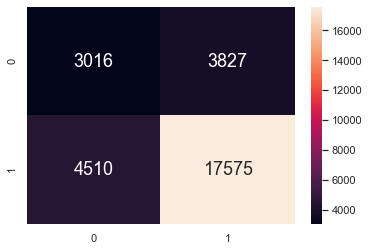

In [37]:
print("Goodness of Fit of Model Test Dataset")
print("Classification Accuracy :", dectree.score(X_test, y_test))
CM = confusion_matrix(y_test, y_test_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
print("True Positive Rate \t:",TP/(TP+FN))
print("True Negative Rate \t:", TN/(TN+FP))
print("False Positive Rate \t:", FP/(FP+TN))
print("False Negative Rate \t:", FN/(FN+TP))
print("Total TP + TN       \t:", TP+TN)
print()

sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

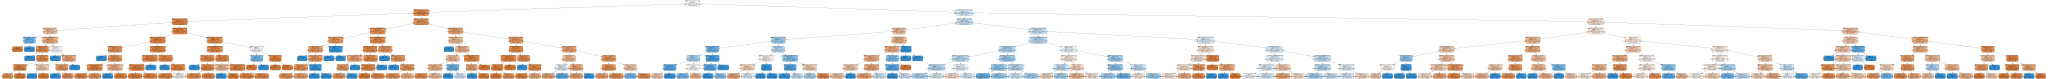

<Figure size 720x720 with 0 Axes>

In [38]:
f = plt.figure(figsize=(10,10))
dot_data = export_graphviz(dectree, 
                                out_file=None, 
                                filled=True, 
                                rounded = True, 
                                feature_names=X_test.columns, 
                                class_names=["Bad","Good"])
graph = graphviz.Source(dot_data)
graph

To also evaluate how well the model has done we plotted a ROC-AUC graph and derived the score in comparison to a random model.

No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.656


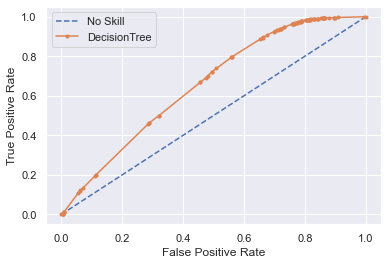

In [39]:
# generate a no skill prediction (majority class)
ns_probs = [1 for y_test in range(len(y_test))]

# predict probabilities
lr_probs = dectree.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Decision Tree: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='DecisionTree')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# show the legend
pyplot.legend()

# show the plot
pyplot.show()

## Random Forest Classfication

Create random forest classification and train the model using train datasets.

Similar to the decision tree classifier, we opted to use a maximum depth of 8.

In [40]:
rforest = RandomForestClassifier(n_estimators = 100, max_depth = 8, class_weight = 'balanced')
rforest.fit(X_train, y_train.values.ravel())                         

RandomForestClassifier(class_weight='balanced', max_depth=8)

Predict Response corresponding to Predictors

In [41]:
y_train_pred = rforest.predict(X_train)
y_test_pred = rforest.predict(X_test)

Check the Goodness of Fit (on Train Data)

Goodness of Fit of Model Train Dataset
Classification Accuracy : 0.7403323193215339
True Positive Rate 	: 0.7957889970568259
True Negative Rate 	: 0.4407423644600322
False Positive Rate 	: 0.5592576355399679
False Negative Rate 	: 0.2042110029431741
Total TP + TN       	: 20591


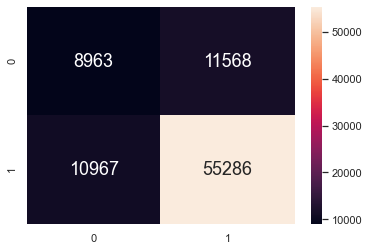

In [42]:
print("Goodness of Fit of Model Train Dataset")
print("Classification Accuracy :", rforest.score(X_train, y_train))
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
print("True Positive Rate \t:",TP/(TP+FN))
print("True Negative Rate \t:", TN/(TN+FP))
print("False Positive Rate \t:", FP/(FP+TN))
print("False Negative Rate \t:", FN/(FN+TP))
print("Total TP + TN       \t:", TP+TN)
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})

Check the Goodness of Fit (on Test Data)

Goodness of Fit of Model Test Dataset
Classification Accuracy : 0.7324737278761062
True Positive Rate 	: 0.7957889970568259
True Negative Rate 	: 0.4407423644600322
False Positive Rate 	: 0.5592576355399679
False Negative Rate 	: 0.2042110029431741
Total TP + TN       	: 20591


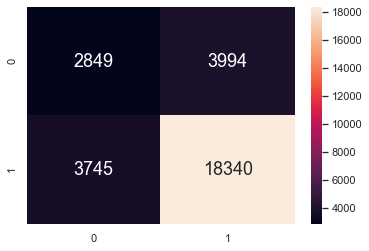

In [43]:
print("Goodness of Fit of Model Test Dataset")
print("Classification Accuracy :", rforest.score(X_test, y_test))

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
print("True Positive Rate \t:",TP/(TP+FN))
print("True Negative Rate \t:", TN/(TN+FP))
print("False Positive Rate \t:", FP/(FP+TN))
print("False Negative Rate \t:", FN/(FN+TP))
print("Total TP + TN       \t:", TP+TN)
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Using the "feature importance" of sklearn

We managed to assign a score to the predictors based on how useful they are at predicting a target variable.

Feature 0 : difference_days

Feature 1  : delivery_days

Feature 2 : freight_value

Feature 3 : price

Feature 4 : installment_payments


Feature: 0, Score: 0.44835
Feature: 1, Score: 0.38395
Feature: 2, Score: 0.08167
Feature: 3, Score: 0.05590
Feature: 4, Score: 0.03012


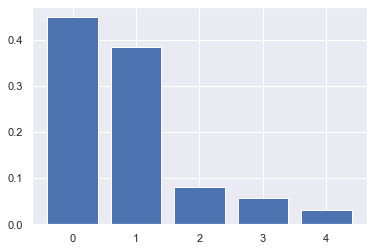

In [44]:
importance = rforest.feature_importances_
# summarise feature importance


for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

 
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Similar to the decision tree classifier, we plotted a ROC-AUC graph and derived the score in comparison to a random model.

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.672


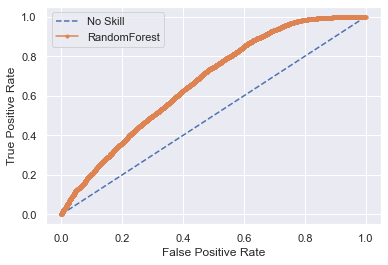

In [45]:
# generate a no skill prediction (majority class)
ns_probs = [1 for y_test in range(len(y_test))]

# predict probabilities
lr_probs = rforest.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='RandomForest')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# show the legend
pyplot.legend()

# show the plot
pyplot.show()

# 5. Outcome and Insights

We made use of 2 different models to predict a customer’s rating on their shopping experience

Difference_days has the strongest influence on the customer ratings.

E-commerce businesses can focus their efforts on improving delivery time of purchases 


# References

https://www.kaggle.com/olistbr/brazilian-ecommerce (Dataset)

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html (Random forest classifier)

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html (decision tree classifier)

https://machinelearningmastery.com/calculate-feature-importance-with-python/ (Feature importance)

https://machinelearningmastery.com/cost-sensitive-decision-trees-for-imbalanced-classification/ (GridSearch)

https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/ (Framework)